# EEG Epilepsy Classification Pipeline - Step by Step Demo

This notebook demonstrates the complete pipeline for epileptic seizure detection using custom wavelet transforms.

**Pipeline Overview:**
1. Load Data
2. Denoise (via DWT soft thresholding)
3. Extract Features (DWT sub-bands)
4. Train/Evaluate Classifier (using full features)
5. Visualize Results (with dimensionality reduction)

We'll start with simple functions and build up to the complete pipeline.


## ⚠️ Kernel Setup

**If you get "cannot load module more than once" errors:**

1. **Restart the kernel**: Kernel → Restart Kernel (or Kernel → Restart & Clear Output)
2. **Then run this cell and the import cell below**

This error occurs when the Jupyter kernel has stale state. Restarting fixes it.


In [ ]:
# Diagnostic: Check numpy and reset if needed
# Run this cell if you get "cannot load module more than once" errors

import sys

# Check if numpy is already imported
if 'numpy' in sys.modules:
    print("⚠️ NumPy is already loaded in this kernel.")
    print("Solution: Restart the kernel (Kernel → Restart Kernel)")
    print("Then re-run all cells from the beginning.")
else:
    print("✓ NumPy not yet loaded - ready for fresh import")


In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import project modules
from data_io.data_loader import (
    load_epilepsy_data, train_test_split, SAMPLING_RATE
)
from core import (
    get_wavelet_filters, periodic_convolve, morlet_wavelet,
    dwt, idwt, dwt_single_level, idwt_single_level,
    cwt, scales_to_frequencies,
    denoise_signal, soft_threshold, hard_threshold
)
from features.extraction import (
    extract_dwt_features, extract_features_batch, get_feature_names,
    compute_energy, compute_entropy
)
from features.projection import reduce_dimensions
from models.classifiers import EEGClassifier, train_and_evaluate
from viz import (
    plot_signals, plot_signal_comparison, plot_scalogram,
    plot_brain_wave_bands, plot_feature_projection, plot_confusion_matrix
)

print("✓ All modules imported successfully!")


  macOS users: Run 'brew install libomp' to install OpenMP runtime.
✓ All modules imported successfully!


## Step 1: Basic Functions - Wavelet Filters

Let's start with the simplest function: getting wavelet filter coefficients. This is the foundation of all wavelet transforms.


Wavelet: db4
Decomposition lowpass filter (dec_lo): [-0.0105974   0.03288301  0.03084138 -0.18703481 -0.02798377  0.63088077
  0.71484657  0.23037781]
Decomposition highpass filter (dec_hi): [-0.23037781  0.71484657 -0.63088077 -0.02798377  0.18703481  0.03084138
 -0.03288301 -0.0105974 ]
Filter length: 8


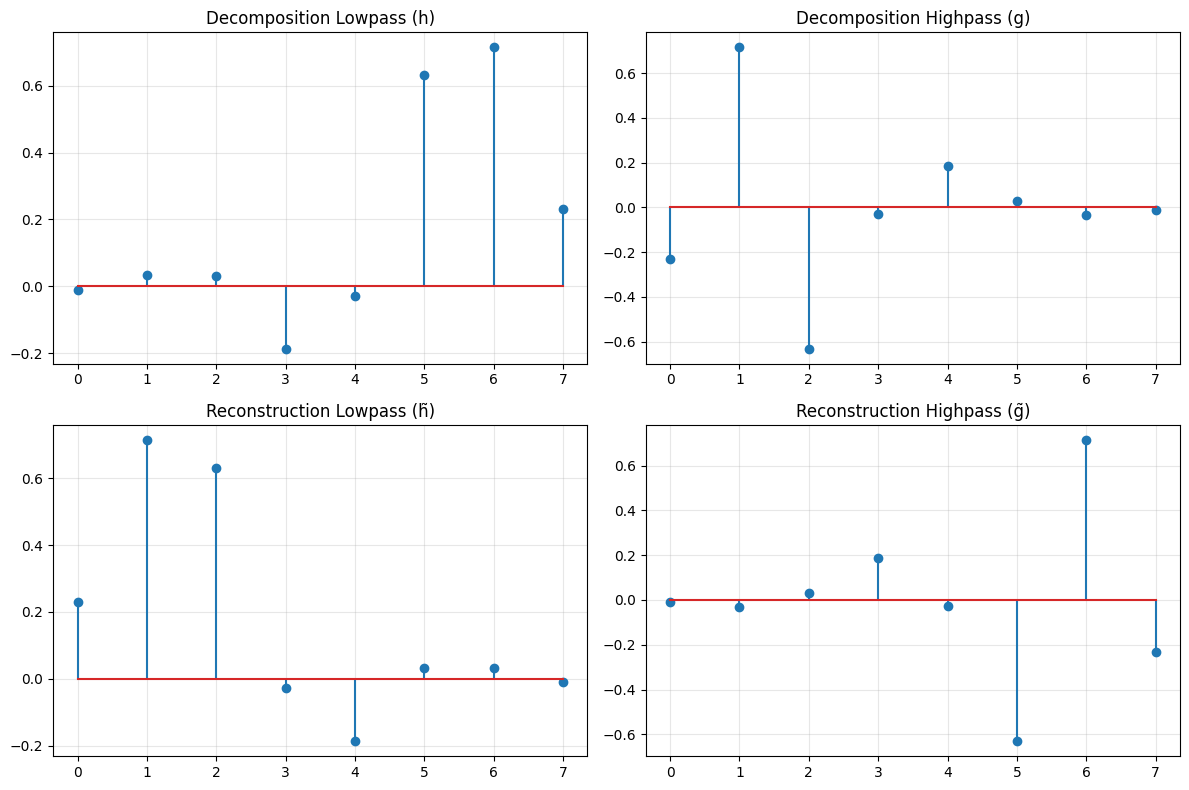

In [2]:
# Get wavelet filter coefficients
# This function uses PyWavelets when available (safer) or falls back to hardcoded coefficients

wavelet_name = 'db4'  # Daubechies-4 wavelet
dec_lo, dec_hi, rec_lo, rec_hi = get_wavelet_filters(wavelet_name)

print(f"Wavelet: {wavelet_name}")
print(f"Decomposition lowpass filter (dec_lo): {dec_lo}")
print(f"Decomposition highpass filter (dec_hi): {dec_hi}")
print(f"Filter length: {len(dec_lo)}")

# Visualize the filters
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes[0, 0].stem(dec_lo)
axes[0, 0].set_title('Decomposition Lowpass (h)')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].stem(dec_hi)
axes[0, 1].set_title('Decomposition Highpass (g)')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].stem(rec_lo)
axes[1, 0].set_title('Reconstruction Lowpass (h̃)')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].stem(rec_hi)
axes[1, 1].set_title('Reconstruction Highpass (g̃)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Step 2: Periodic Convolution

Periodic (circular) convolution is the core operation in DWT. It handles boundary conditions by wrapping around.


Original signal: [1. 2. 3. 4. 5. 6. 7. 8.]
Filter coefficients: [0.5 0.5]
Convolution result: [4.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5]


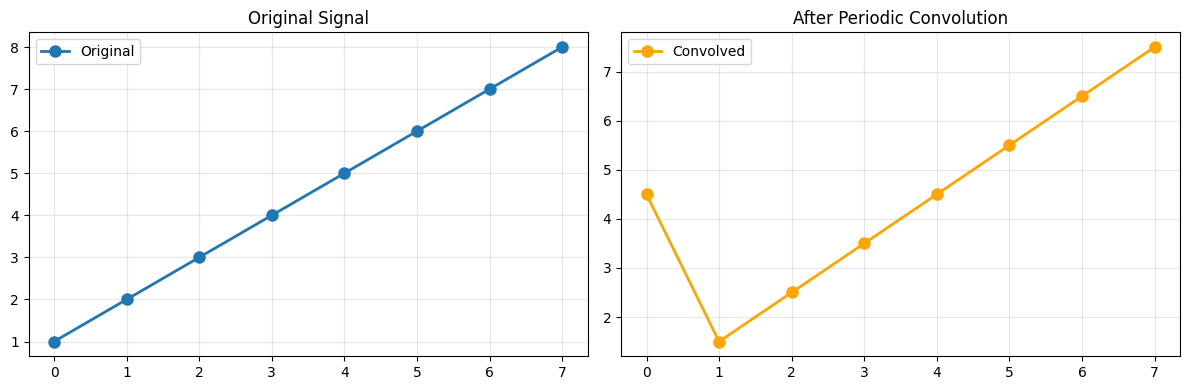

In [3]:
# Create a simple test signal
signal = np.array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0])
filter_coeffs = np.array([0.5, 0.5])  # Simple averaging filter

# Perform periodic convolution
result = periodic_convolve(signal, filter_coeffs)

print(f"Original signal: {signal}")
print(f"Filter coefficients: {filter_coeffs}")
print(f"Convolution result: {result}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(signal, 'o-', label='Original', linewidth=2, markersize=8)
axes[0].set_title('Original Signal')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

axes[1].plot(result, 'o-', label='Convolved', linewidth=2, markersize=8, color='orange')
axes[1].set_title('After Periodic Convolution')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()


## Step 3: Single-Level DWT Decomposition

A single level of DWT splits a signal into approximation (low-frequency) and detail (high-frequency) coefficients.


Original signal (length 8): [1. 2. 3. 4. 5. 6. 7. 8.]

Approximation coefficients (length 4): [ 2.12132034  4.94974747  7.77817459 10.60660172]
Detail coefficients (length 4): [-0.70710678 -0.70710678 -0.70710678 -0.70710678]


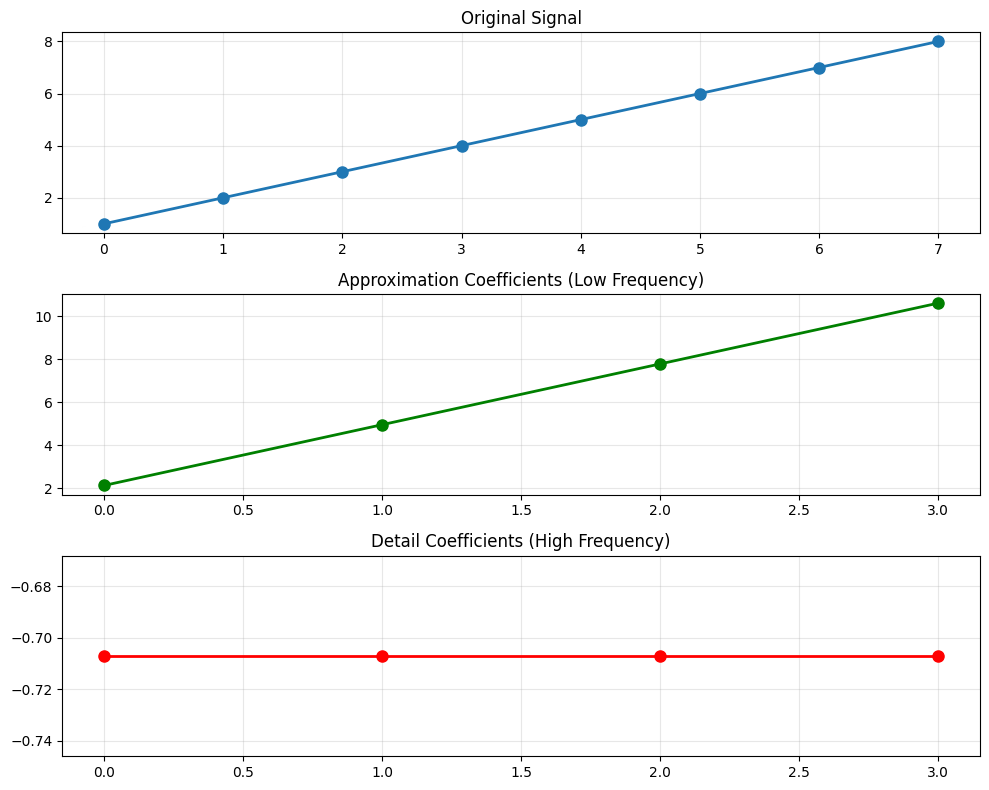

In [4]:
# Create a test signal
signal = np.array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0])
wavelet = 'haar'  # Simple Haar wavelet for demonstration

# Get filters
dec_lo, dec_hi, _, _ = get_wavelet_filters(wavelet)

# Single-level decomposition
approx, detail = dwt_single_level(signal, dec_lo, dec_hi)

print(f"Original signal (length {len(signal)}): {signal}")
print(f"\nApproximation coefficients (length {len(approx)}): {approx}")
print(f"Detail coefficients (length {len(detail)}): {detail}")

# Visualize
fig, axes = plt.subplots(3, 1, figsize=(10, 8))
axes[0].plot(signal, 'o-', linewidth=2, markersize=8)
axes[0].set_title('Original Signal')
axes[0].grid(True, alpha=0.3)

axes[1].plot(approx, 'o-', linewidth=2, markersize=8, color='green')
axes[1].set_title('Approximation Coefficients (Low Frequency)')
axes[1].grid(True, alpha=0.3)

axes[2].plot(detail, 'o-', linewidth=2, markersize=8, color='red')
axes[2].set_title('Detail Coefficients (High Frequency)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Step 4: Multi-Level DWT and Perfect Reconstruction

Multi-level DWT recursively decomposes the approximation coefficients. We can perfectly reconstruct the original signal from the coefficients.


  DWT decomposition: 64 samples → 6 levels (wavelet: haar)
    Level 1: length 64 → 32
    Level 2: length 32 → 16
    Level 3: length 16 → 8
    Level 4: length 8 → 4
    Level 5: length 4 → 2
    Level 6: length 2 → 1
  Final approximation length: 1

Coefficient structure:
  Final approximation (level 6): length 1
  Detail level 6: length 1
  Detail level 5: length 2
  Detail level 4: length 4
  Detail level 3: length 8
  Detail level 2: length 16
  Detail level 1: length 32
  IDWT reconstruction: 6 levels (wavelet: haar)
    Level 1: length 1 → 2
    Level 2: length 2 → 4
    Level 3: length 4 → 8
    Level 4: length 8 → 16
    Level 5: length 16 → 32
    Level 6: length 32 → 64

✓ Reconstruction error: 8.88e-16


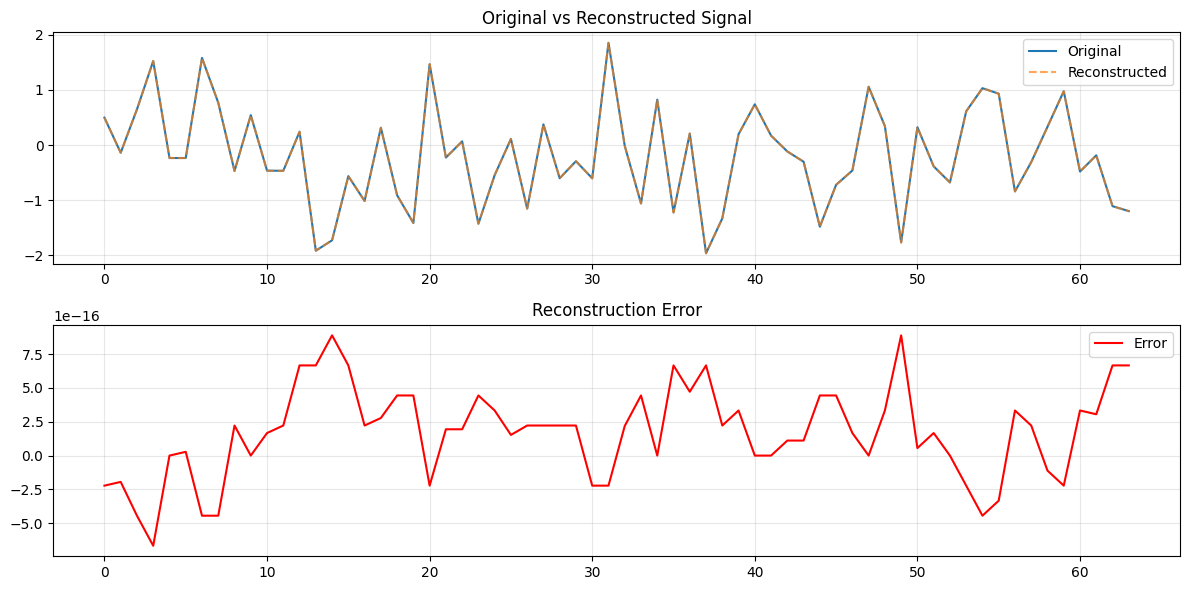

In [10]:
# Create a more complex signal
np.random.seed(42)
signal = np.random.randn(64)
wavelet = 'haar'
level = 6

# Multi-level decomposition
coeffs = dwt(signal, wavelet=wavelet, level=level, verbose=True)

print(f"\nCoefficient structure:")
print(f"  Final approximation (level {level}): length {len(coeffs[0])}")
for i in range(1, len(coeffs)):
    print(f"  Detail level {len(coeffs) - i}: length {len(coeffs[i])}")

# Perfect reconstruction
reconstructed = idwt(coeffs, wavelet=wavelet, original_length=len(signal), verbose=True)

# Check reconstruction error
error = np.max(np.abs(signal - reconstructed))
print(f"\n✓ Reconstruction error: {error:.2e}")

# Visualize
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
axes[0].plot(signal, label='Original', linewidth=1.5)
axes[0].plot(reconstructed, '--', label='Reconstructed', linewidth=1.5, alpha=0.7)
axes[0].set_title('Original vs Reconstructed Signal')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(signal - reconstructed, label='Error', linewidth=1.5, color='red')
axes[1].set_title('Reconstruction Error')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Step 5: Continuous Wavelet Transform (CWT)

CWT provides a time-frequency representation by convolving the signal with scaled versions of a mother wavelet.


In [ ]:
# Create a test signal with multiple frequencies
t = np.linspace(0, 1, 128)
signal = np.sin(2 * np.pi * 10 * t) + 0.5 * np.sin(2 * np.pi * 30 * t)
sampling_rate = 128  # Hz

# Compute CWT
scales = np.arange(1, 32)
cwt_coeffs = cwt(signal, scales, wavelet='morlet', sampling_rate=sampling_rate)

# Convert scales to frequencies
frequencies = scales_to_frequencies(scales, 'morlet', sampling_rate, omega0=5.0)

print(f"Signal length: {len(signal)}")
print(f"Number of scales: {len(scales)}")
print(f"CWT coefficients shape: {cwt_coeffs.shape}")
print(f"Frequency range: {frequencies[-1]:.2f} - {frequencies[0]:.2f} Hz")

# Visualize scalogram
fig = plot_scalogram(
    cwt_coeffs, scales=scales, frequencies=frequencies,
    sampling_rate=sampling_rate,
    title="CWT Scalogram (Morlet Wavelet)",
    show_frequencies=True
)
plt.show()


## Step 6: Wavelet Denoising

DWT can be used to denoise signals by thresholding detail coefficients (which contain noise).


In [ ]:
# Create a clean signal
t = np.linspace(0, 1, 128)
clean_signal = np.sin(2 * np.pi * 10 * t)

# Add noise
noise = 0.3 * np.random.randn(len(clean_signal))
noisy_signal = clean_signal + noise

# Denoise using soft thresholding
denoised = denoise_signal(noisy_signal, wavelet='db4', level=3, 
                          threshold_type='soft', verbose=True)

# Calculate SNR improvement
snr_before = 10 * np.log10(np.var(clean_signal) / np.var(noise))
snr_after = 10 * np.log10(np.var(clean_signal) / np.var(denoised - clean_signal))

print(f"\nSNR before denoising: {snr_before:.2f} dB")
print(f"SNR after denoising: {snr_after:.2f} dB")
print(f"SNR improvement: {snr_after - snr_before:.2f} dB")

# Visualize
fig = plot_signal_comparison(
    noisy_signal, denoised,
    sampling_rate=128,
    labels=["Noisy", "Denoised"],
    title="Wavelet Denoising (Soft Thresholding)"
)
plt.show()


## Step 7: Feature Extraction from DWT Coefficients

For classification, we extract statistical features (energy, entropy, std) from each DWT sub-band corresponding to EEG frequency bands.


In [ ]:
# Create a test EEG-like signal
signal = np.random.randn(178)  # Typical EEG segment length
wavelet = 'db4'
level = 5  # 5 levels for EEG bands (delta, theta, alpha, beta, gamma)

# Extract features
features = extract_dwt_features(signal, wavelet=wavelet, level=level, feature_set='standard')
feature_names = get_feature_names(level, 'standard')

print(f"Signal length: {len(signal)}")
print(f"Number of features extracted: {len(features)}")
print(f"\nFeature breakdown:")
print(f"  - {level + 1} sub-bands (1 approximation + {level} details)")
print(f"  - 3 features per sub-band (energy, entropy, std)")
print(f"  - Total: {(level + 1) * 3} features")

print(f"\nFeature names:")
for i, (name, value) in enumerate(zip(feature_names, features)):
    print(f"  {i+1:2d}. {name:20s} = {value:.4f}")

# Visualize DWT decomposition
coeffs = dwt(signal, wavelet=wavelet, level=level, verbose=False)
fig = plot_brain_wave_bands(
    coeffs,
    band_names=['δ (Delta)', 'θ (Theta)', 'α (Alpha)', 'β (Beta)', 'γ (Gamma)', 'HF'][:len(coeffs)],
    title="EEG Brain Wave Decomposition"
)
plt.show()


## Step 8: Loading EEG Data

Load the UCI Epileptic Seizure Recognition dataset and prepare it for processing.


In [ ]:
# Load dataset
data_path = Path("Epileptic Seizure Recognition.csv")

if data_path.exists():
    X, y = load_epilepsy_data(data_path, binary=True, normalize=True, verbose=True)
    
    # Split into train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=True, random_state=42
    )
    
    print(f"\nDataset loaded successfully!")
    print(f"  Training set: {len(X_train)} samples")
    print(f"  Test set: {len(X_test)} samples")
    print(f"  Signal length: {X_train.shape[1]} samples")
    print(f"  Sampling rate: {SAMPLING_RATE} Hz")
    
    # Visualize sample signals from each class
    seizure_idx = np.where(y_train == 1)[0][0]
    non_seizure_idx = np.where(y_train == 0)[0][0]
    
    fig = plot_signals(
        [X_train[seizure_idx], X_train[non_seizure_idx]],
        labels=["Seizure", "Non-Seizure"],
        sampling_rate=SAMPLING_RATE,
        title="Sample EEG Signals",
        stacked=True
    )
    plt.show()
else:
    print(f"Dataset not found at {data_path}")
    print("Please ensure 'Epileptic Seizure Recognition.csv' is in the project directory")


## Step 9: Complete Pipeline - Denoising

Apply DWT soft thresholding to denoise all signals in the dataset.


In [ ]:
if 'X_train' in locals():
    # Denoise training signals
    print("Denoising training signals...")
    X_train_denoised = np.zeros_like(X_train)
    for i in range(len(X_train)):
        if (i + 1) % 2000 == 0:
            print(f"  Processing signal {i+1}/{len(X_train)}")
        X_train_denoised[i] = denoise_signal(X_train[i], wavelet='db4', level=3, verbose=False)
    
    # Denoise test signals
    print("Denoising test signals...")
    X_test_denoised = np.zeros_like(X_test)
    for i in range(len(X_test)):
        X_test_denoised[i] = denoise_signal(X_test[i], wavelet='db4', level=3, verbose=False)
    
    print("✓ Denoising complete!")
    
    # Visualize denoising effect on a sample
    sample_idx = 0
    fig = plot_signal_comparison(
        X_train[sample_idx], X_train_denoised[sample_idx],
        sampling_rate=SAMPLING_RATE,
        labels=["Original", "Denoised"],
        title="DWT Denoising Effect"
    )
    plt.show()
else:
    print("Please run the data loading cell first!")


## Step 10: Feature Extraction (Batch Processing)

Extract DWT features from all denoised signals. This creates the feature matrix for classification.


In [ ]:
if 'X_train_denoised' in locals():
    # Extract features from training set
    print("Extracting features from training set...")
    features_train = extract_features_batch(
        X_train_denoised, wavelet='db4', level=5,
        feature_set='standard', verbose=True
    )
    
    # Extract features from test set
    print("\nExtracting features from test set...")
    features_test = extract_features_batch(
        X_test_denoised, wavelet='db4', level=5,
        feature_set='standard', verbose=True
    )
    
    feature_names = get_feature_names(5, 'standard')
    
    print(f"\n✓ Feature extraction complete!")
    print(f"  Training features shape: {features_train.shape}")
    print(f"  Test features shape: {features_test.shape}")
    print(f"  Number of features per sample: {features_train.shape[1]}")
    print(f"\n  Feature names: {feature_names[:5]}... (showing first 5)")
    
    # Show feature statistics
    print(f"\nFeature statistics (training set):")
    print(f"  Mean: {np.mean(features_train, axis=0)[:5]}")
    print(f"  Std:  {np.std(features_train, axis=0)[:5]}")
else:
    print("Please run the denoising cell first!")


## Step 11: Classification (Using Full Features)

Train a classifier using ALL extracted features (no dimensionality reduction). This gives the best performance.


In [ ]:
if 'features_train' in locals():
    print("Training classifier with FULL features (no dimensionality reduction)...")
    print(f"  Using all {features_train.shape[1]} features")
    print(f"  Classifier: SVM\n")
    
    # Train and evaluate
    classifier, results = train_and_evaluate(
        features_train, y_train, features_test, y_test,
        model_type='svm', verbose=True
    )
    
    # Visualize confusion matrix
    fig = plot_confusion_matrix(
        results['confusion_matrix'],
        class_names=['Non-Seizure', 'Seizure'],
        title="Classification Results (Full Features)",
        normalize=True
    )
    plt.show()
    
    print("\n" + "="*70)
    print("Classification Summary")
    print("="*70)
    print(f"Test Accuracy:  {results['test_metrics']['accuracy']:.4f}")
    print(f"Test Precision: {results['test_metrics']['precision']:.4f}")
    print(f"Test Recall:    {results['test_metrics']['recall']:.4f}")
    print(f"Test F1 Score:  {results['test_metrics']['f1']:.4f}")
    print(f"Test ROC-AUC:   {results['test_metrics']['roc_auc']:.4f}")
else:
    print("Please run the feature extraction cell first!")


## Step 12: Visualization (Dimensionality Reduction for Display Only)

Use PCA/UMAP/t-SNE to visualize the feature space in 2D. **Note:** This is for visualization only - classification uses full features!


In [ ]:
if 'features_train' in locals():
    # Reduce dimensions for visualization (NOT for classification!)
    print("Reducing dimensions for visualization (PCA)...")
    print("  Note: This is for display only - classification used full features!\n")
    
    reduced_train, reducer = reduce_dimensions(
        features_train, method='pca', n_components=2
    )
    
    # Get explained variance
    var_explained = reducer.get_explained_variance()
    if var_explained is not None:
        print(f"Explained variance: {var_explained[0]:.2%}, {var_explained[1]:.2%}")
        print(f"Total explained: {sum(var_explained):.2%}\n")
    
    # Visualize feature space
    fig = plot_feature_projection(
        reduced_train, y_train,
        method_name='PCA',
        class_names=['Non-Seizure', 'Seizure'],
        title="EEG Feature Space - PCA Projection (Visualization Only)"
    )
    plt.show()
    
    print("\n✓ Visualization complete!")
    print("  The classifier was trained on all features, not this 2D projection.")
else:
    print("Please run the feature extraction cell first!")


## Summary

This notebook demonstrated the complete EEG Epilepsy Classification pipeline:

1. **Basic Functions**: Wavelet filters, periodic convolution
2. **Single-Level DWT**: Decomposition into approximation and detail
3. **Multi-Level DWT**: Recursive decomposition with perfect reconstruction
4. **CWT**: Time-frequency representation with scalograms
5. **Denoising**: Soft thresholding for noise removal
6. **Feature Extraction**: Statistical features from DWT sub-bands
7. **Data Loading**: UCI Epileptic Seizure Recognition dataset
8. **Complete Pipeline**: Denoising → Feature Extraction → Classification
9. **Classification**: Using **ALL features** (no dimensionality reduction)
10. **Visualization**: PCA/UMAP/t-SNE for display only

### Key Points:
- ✅ DWT provides perfect reconstruction (error < 1e-15)
- ✅ Classification uses **full feature space** for best performance
- ✅ Dimensionality reduction is **only for visualization**
- ✅ Modular design allows easy experimentation

### Next Steps:
- Try different wavelets (db2, db6, sym4, etc.)
- Experiment with different feature sets ('full', 'minimal')
- Try different classifiers (XGBoost)
- Adjust denoising parameters
- Explore different projection methods (UMAP, t-SNE)
